# Dynamic Mode Decomposition - Time Series Forecasting

Dynamic mode decomposition (DMD) is a dimensionality reduction technique using singular value decomposition to extract spatial temporal dynamics from periodic data. Energy prices in the CAISO are a prime example of a periodic data set. This notebook will go over how to augment time series data to be able to exploit DMD as a forecasting tool.

**Source code available in base repository /my_ml_code/dmd.py**

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg as la

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1

In [2]:
import sys
sys.path.insert(1, './../../')

In [3]:
from my_ml_code import dmd

In [4]:
path = './../../datasets/all_prices.csv'
df = pd.read_csv(path, header=None)
X = df.to_numpy()

# EDA

California energy prices clearly have a periodic nature which should be able to be exploited from DMD. The graph below gives a base idea of the input-output data for DMD training.

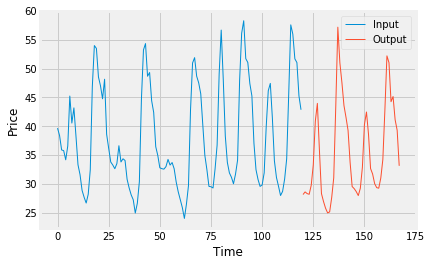

In [5]:
node = 133
start = 23
m = 24*5
n = 48

def plot_prices(X, start, m, n, node):

    end_train = start + m
    end_test = end_train + n + 1
    t_in = np.arange(m)
    t_out = np.arange(n) + max(t_in) + 1
    input_y = X[node][start:end_train]
    output_y = X[node][end_train + 1:end_test]
    
    fig, ax = plt.subplots()
    ax.plot(t_in, input_y, label ='Input')
    ax.plot(t_out, output_y, label='Output')
    ax.set_ylabel('Price')
    ax.set_xlabel('Time')
    ax.legend()
    return fig, ax

fig, ax = plot_prices(X, start, m, n, node)

# Mathematics 

**The following formulation was taken from my thesis written on DMD**

The following decomposition information is taken from Kutz’s book “Dynamic Mode Decomposition” and is consistent with the original formulation from Schmid et. al. It is important to define the basics of DMD that will be used in order to model the system in question. DMD starts with an input matrix $X_t$ where the columns of $X_t$ are the spacial data in question and each column represents a discrete time measurement. Therefore, $X_t$ has m rows where m is the number of spacial points and n columns where n is the number of time measurements. The matrix $X_t$ can then be split into two matrices as shown below. Note that each $\textbf{x}_{i}$ is a column of spacial data in $X_t$.

$$X^f = [\textbf{x}_{1} \cdots \textbf{x}_{n} ]$$   
$$X = [\textbf{x}_{i} \cdots \textbf{x}_{n - 1}]$$   
$$X' = [\textbf{x}_{i} \cdots  \textbf{x}_{n-1}]$$

Once $X_t$ has been split, the overall goal of DMD is to produce a best fit linear operator with the following property. 

$$AX ≈ X'$$

This best fit operator $A$ will be the forecasting operator that allows for the prediction of future measurements. The following decomposition allows for the construction of the $A$ matix. Note that * indicates a conjugate transpose as DMD can be applied to complex systems as well as real systems. Also, note that equation 3 is just a singular value decomposition of $X$. 

$$X=UΣV^*$$
$$A=U^* X' VΣ^{-1}$$

*Important mathematical note: rank truncation of the SVD is performed between Equations 3 and 4. The number of singular values used can range from 1 to the number of time measurements.*

The matrix $A$ is then projected onto the modes given by the matrix U and a standard eigen decomposition is performed on the reduced matrix $\overset{~}{A}$ in Equation 6. This is useful because the matrix $A$ can be greatly reduced in dimensions with some simple truncation of singular values in Equation 4. 

$$\overset{~}{A}=U^* AU$$
$$\overset{~}{A}W=WΛ$$

Lastly, the DMD modes are defined in Equation 7. These modes can then be used to estimate any column of data at a given time, $x(t)$. Equation 8 shows how to obtain this prediction. $Ω$ is a diagonal matrix that contains the natural logarithm of eigen values divided by the difference in time, $Δt$ , given along the diagonal of $Λ$ i.e. $Ω_ii=(〖ln⁡(λ〗_i))/Δt$  . The vector $b$ is given by solving the linear system given in Equation 9 where $x_1$ is the first column of the $X$ matrix.

$$Φ=X' VΣ^{-1} W$$
$$x(X_t,t)=Φ exp⁡(Ωt)b$$
$$Φb=x_1$$

At this point the decomposition of the original data is done, and forecasting can be performed in any fashion desired with a given dataset by using Equation 8. Also, the reconstruction of the original data can be obtained from the DMD composition as shown in Equations 10 and 11. Note the $D$ matrix stands for the dynamics of the system. $D$ is constructed by using Equation 8 at every time step in the training set. Equation 10 shows how one column ($D_{(:,j)}$) would be constructed using Equation 8. Also note the $j$ index on $D$ corresponds with $t_j$ where $t_j$ comes from the $j^{th}$ input timestep in the input time vector. This makes each column of $D$ correspond to the time dynamics at each input time. 

$$D_{(:,j)}= Φ exp⁡(Ωt_j )b$$ 
$$X_{DMD}=ΦD$$


Lastly, the DMD modes are defined in Equation 7. These modes can then be used to estimate any column of data at a given time, $x(t)$. Equation 8 shows how to obtain this prediction. $\Omega$ is a diagonal matrix that contains the natural logarithm of eigen values divided by the difference in time, $\Delta t$ , given along the diagonal of $\Lambda$ i.e. $\Omega_ii=((ln⁡(\lambda)_i))/ \Delta t$  . The vector $b$ is given by solving the linear system given in Equation 9 where $x_1$ is the first column of the $X$ matrix.

$$\Phi=X' V\Sigma^{-1} W$$
$$x(X_t,t)=\Phi exp⁡(\Omega t)b$$
$$\Phi b=x_1$$

At this point the decomposition of the original data is done, and forecasting can be performed in any fashion desired with a given dataset by using Equation 8. Also, the reconstruction of the original data can be obtained from the DMD composition as shown in Equations 10 and 11. Note the $D$ matrix stands for the dynamics of the system. $D$ is constructed by using Equation 8 at every time step in the training set. Equation 10 shows how one column ($D_{(:,j)}$) would be constructed using Equation 8. Also note the $j$ index on $D$ corresponds with $t_j$ where $t_j$ comes from the $j^{th}$ input time step in the input time vector. This makes each column of $D$ correspond to the time dynamics at each input time. 

$$D_{(:,j)}= \Phi exp⁡(\Omega t_j )b$$ 
$$X_{DMD}=\Phi D$$

# DMD Example - Spatial-Temporal Data

To show how DMD can be performed using the class given
let us take a look at an example from Kutz's book on DMD

We will look at a complex, periodic function given below:

f(x,t) = sech(x+3)exp(2.3it) + 2sech(x)tanh(x)exp(2.8it)

Now, the 3D function will be plotted on a surface plot as well as its
DMD reconstruction based on rank reduction at 1,2, and 3 singular values.

It can be shown that this function only has rank = 2, so notice how the DMD
reconstruction at rank = 3 is pretty much identical to the rank = 2 surface.



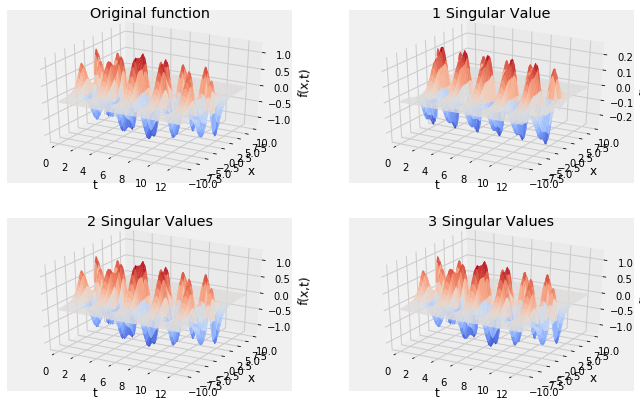

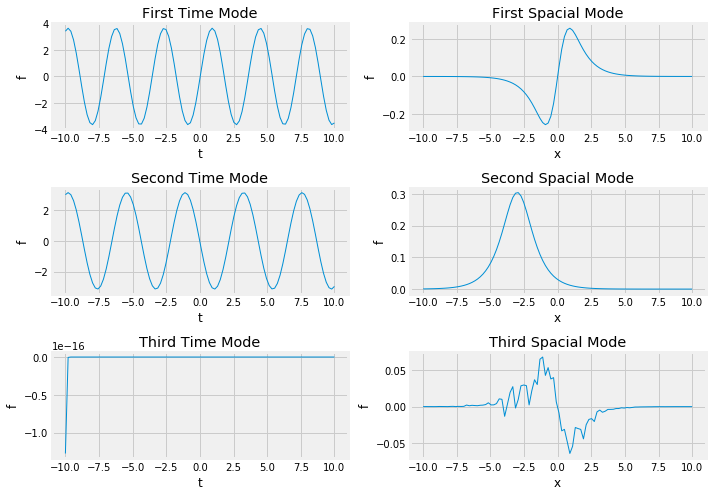

In [10]:
dmd.examples.kutz()
plt.show()

# Forecasting Preprocessing - Data Augmenting

One of the most important things that must occur for DMD to work on stagnant time series such as the one shown above in the EDA section is what is called data augmentation. This is a process where the "standing wave" time series is converted into a matrix of "augmented" time series. This augmented data can then be processed by DMD to extract a periodic nature. 

The function below shows a representation of how to augment a time series. *Source code is included in the base repository*

In [89]:
x = np.arange(10)
X_aug = dmd.augment.augment_matrix(x,3)
print('Original Vector:',x)
print('Augmented Matrix (Level 3):'); print(X_aug)

Original Vector: [0 1 2 3 4 5 6 7 8 9]
Augmented Matrix (Level 3):
[[0 1 2 3 4 5 6 7]
 [1 2 3 4 5 6 7 8]
 [2 3 4 5 6 7 8 9]]


Now the process of augmenting a dataset has beeen established, let's apply this to some of the energy prices to see what this will look like.

Original Vector Shape: (192,)
Augmented Matrix Shape: (96, 97)


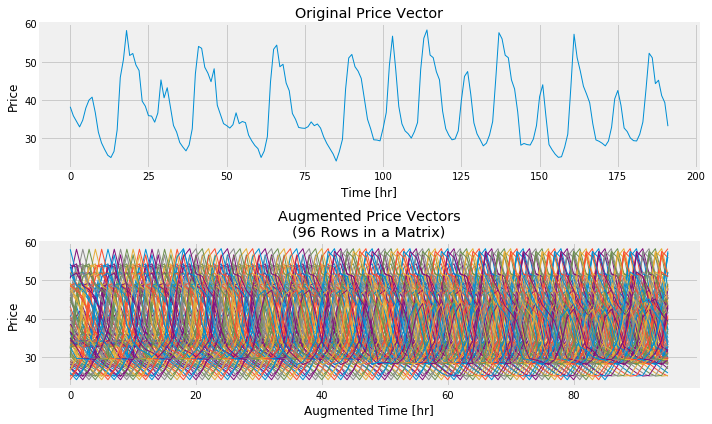

In [90]:
num_rows = 96
len_rows = 96
loc = 133

x = X[loc][0:len_rows+num_rows]
X_aug = dmd.augment.augment_matrix(x ,num_rows)

print('Original Vector Shape:', x.shape)
print('Augmented Matrix Shape:', X_aug.shape)

fig, ax = plt.subplots(2,1, figsize = (10,6))
ax[0].plot(x)
ax[0].set_ylabel('Price')
ax[0].set_xlabel('Time [hr]')
ax[0].set_title('Original Price Vector')

ax[1].plot(X_aug)
ax[1].set_ylabel('Price')
ax[1].set_xlabel('Augmented Time [hr]')
ax[1].set_title('Augmented Price Vectors\n(96 Rows in a Matrix)')
fig.tight_layout()
plt.show()

# DMD Applied to Energy Prices

With the DMD formulated and the concept of augmentation covered, now I will apply the DMD algorithm to the energy prices which have previously been explored.

## Condition Number Exploration
The basis of DMD is the singular value decomposition. The decomposition of the augmented data at various levels shows the need for augmenting the original time series - the condition number. Differing levels of augmentation create better conditioning which allows for SVD to capture more of the underying dynamics.

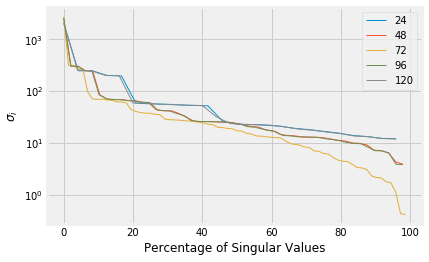

In [91]:
y = X[loc][0:24*6]
aug_levels = (np.arange(5) + 1)*24

fig, ax = plt.subplots()
for a in aug_levels:
    x_aug = dmd.augment.augment_matrix(y, n=a)
    U, S, Vt = la.svd(x_aug)
    percent_vec = np.arange(S.shape[0]) / S.shape[0] * 100
    ax.semilogy(percent_vec, S, label=a)
ax.legend()
ax.set_xlabel('Percentage of Singular Values')
ax.set_ylabel('$\sigma_i$')
plt.show()

For a 6 day timeseries, it makes sense that a level 72 augmentation would produce the highest condition number as the output matix is almost completely square at that point. Because of this, we will use the rule of $n=72$ for augmentation throughout the modeling process.

## Singular Value Truncation 

With the level 72 augmentation process, the following code explores the reconstruction of the datasource at various level on singular value truncation. The reconstruction at various levels of singular value tranction suggests that ~5 singular values are needed to capture the variance in the vector.

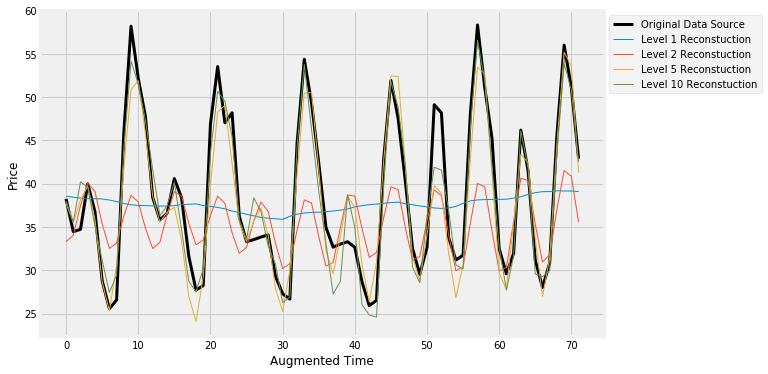

In [92]:
x_aug = dmd.augment.augment_matrix(y, n=72)
U, S_diag, Vt = la.svd(x_aug)
S = np.zeros(x_aug.shape)
np.fill_diagonal(S, S_diag)

fig, ax = plt.subplots(figsize=(9,6))
ax.plot(np.diag(x_aug), label=f'Original Data Source', color='k', linewidth=3)

levels = [1,2,5,10]
for level in levels:
    S_cut = S.copy()
    cut_inds = np.arange(min(S_cut.shape) - level) + level
    S_cut[cut_inds, cut_inds] = 0
    x_recon = U@S_cut@Vt
    ax.plot(np.diag(x_recon), label=f'Level {level} Reconstuction')


ax.set_ylabel('Price')
ax.set_xlabel('Augmented Time')
ax.legend(bbox_to_anchor = (1,1))
plt.show()

In [93]:
level = 5
S_cut = S.copy()
cut_inds = np.arange(min(S_cut.shape) - level) + level
S_cut[cut_inds, cut_inds] = 0
x_recon = U@S_cut@Vt
error = (la.norm(x_recon - x_aug) / la.norm(x_aug)) * 100
print(f'2-Norm Reconstruction Loss: {error:.2f}%')

2-Norm Reconstruction Loss: 9.19%


## DMD Decomposition
With the intutive knowledge of the singular value decomposition of the timeseries, DMD can then be applied with some intution of the nuances of the time series. The following decomposition details the results when DMD is applied to the augmented data.

In [94]:
time = np.arange(x_aug.shape[1])
rank=5
dmd_results = dmd.dmd.decomp(x_aug, time, svd_cut=True, num_svd=rank)

print(f'2-Norm Reconstruction Loss: {dmd_results.error:.2f}%')

2-Norm Reconstruction Loss: 9.47%


5 spatial temporal modes (out of 72) are able to capture >90% of the variance in the augmented data. This matches very similar to the 2-Norm reconstruction loss of the SVD reconstruction from the above section as well. However, this method will allow for the prediction of periodic signal that SVD alone will not do.

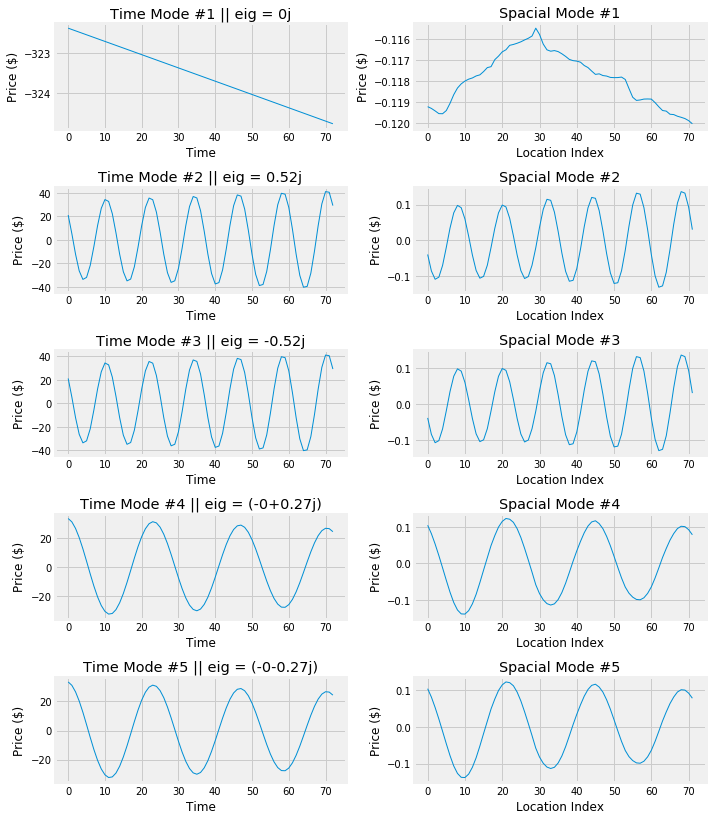

In [95]:
fig = dmd.dmd.mode_analysis(x_aug ,dmd_results, N = np.arange(5), analyze = False, plot = True)

The 5 periodic modes identified by the DMD alorithm are shown above. These modes can then be used for prediction of future temporal behavior.

## Forecasting Example
All that math, SVD, and mode analysis is cool, but what we really want to do is to predict the future prices. The following code shows how to take in a given timeseries and predict N steps into the future. 

In [154]:
n_in = 6*24
n_out = 48
start = 0
aug_level = 72
rank = 5

x_train = X[loc][start:start+n_in]
x_test = X[loc][start+n_in+1:start+n_in+1+n_out]
x_train_aug = dmd.augment.augment_matrix(x_train, n=aug_level)

t_train = np.arange(x_train.shape[0])
t_train_aug = np.arange(max(x_train_aug.shape))
t_test = np.arange(x_test.shape[0]) + 1 + max(t_train)
t_test_aug = np.arange(x_test.shape[0]) + 1 + max(t_train_aug)

print('Input shape',x_train.shape)
print('Augmented Input shape',x_train_aug.shape)
print('Output shape',x_test.shape)

Input shape (144,)
Augmented Input shape (72, 73)
Output shape (48,)


In [155]:
dmd_results = dmd.dmd.decomp(x_train_aug, t_train_aug, svd_cut=True, num_svd=rank)
x_test_pred = []
for t in t_test:
    x_test_pred.append(dmd.dmd.predict(dmd_results, t))
x_test_pred = np.array(x_test_pred).T[0]
mae = np.mean(np.abs(x_test_pred - x_test))
mape = np.mean(np.abs(x_test_pred - x_test) / x_test) * 100
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Absolute Percent Error: {mape:.2f}%')

Mean Absolute Error: 5.87
Mean Absolute Percent Error: 16.42%


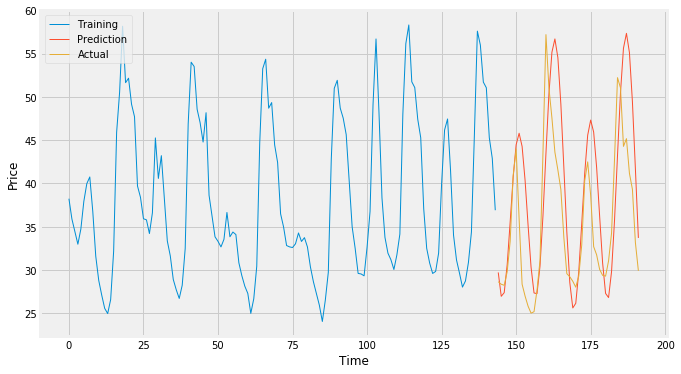

In [156]:
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(t_train, x_train, label = 'Training')
ax.plot(t_test, x_test_pred, label = 'Prediction')
ax.plot(t_test, x_test, label = 'Actual')
ax.set_ylabel('Price')
ax.set_xlabel('Time')
ax.legend()
plt.show()

## Looping the Forecast Throughout the Year
Now with the forecast code ready, we can loop through all days available in the training set to get a distribution of error throughout the year.

In [175]:
n_in = 6*24
n_out = 48
aug_level = 72
loc = 133
rank = 5
timeseries = X[loc]
days = np.arange((timeseries.shape[0] - n_in - n_out) / 24 - 1)

mae_vec = []
mape_vec = []
for day in days:
    
    start = int(day*24)
    
    x_train = timeseries[start:start+n_in]
    x_test = timeseries[start+n_in+1:start+n_in+1+n_out]
    x_train_aug = dmd.augment.augment_matrix(x_train, n=aug_level)

    t_train = np.arange(x_train.shape[0])
    t_train_aug = np.arange(max(x_train_aug.shape))
    t_test = np.arange(x_test.shape[0]) + 1 + max(t_train)
    t_test_aug = np.arange(x_test.shape[0]) + 1 + max(t_train_aug)

    dmd_results = dmd.dmd.decomp(x_train_aug, t_train_aug, svd_cut=True, num_svd=rank)
    x_test_pred = []
    for t in t_test:
        x_test_pred.append(dmd.dmd.predict(dmd_results, t))
    x_test_pred = np.array(x_test_pred).T[0]

    mae = np.mean(np.abs(x_test_pred - x_test))
    mape = np.mean(np.abs(x_test_pred - x_test) / x_test) * 100
    mae_vec.append(mae)
    mape_vec.append(mape)

mae_vec = np.array(mae_vec)
mape_vec = np.array(mape_vec)

MAE Average 7.10	MAPE Average 16.67		


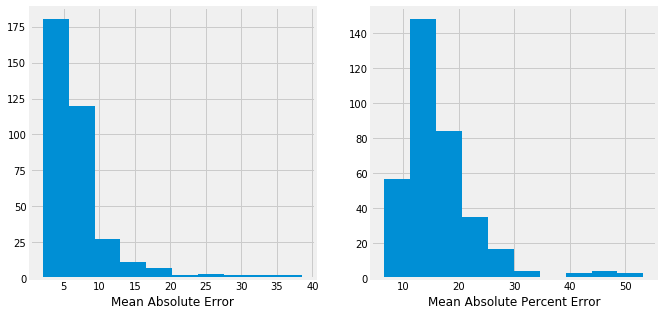

In [186]:
print(f'MAE Average {np.mean(mae_vec):.2f}\tMAPE Average {np.mean(mape_vec):.2f}\t\t')
fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].hist(mae_vec)
ax[1].hist(mape_vec)
ax[0].set_xlabel('Mean Absolute Error')
ax[1].set_xlabel('Mean Absolute Percent Error')
plt.show()

# Computation Considerations
The wallclock time to train, predict and evaluate metrics for 350 days in this forecasting metric only to 1.5 seconds on my macbook pro (no GPU support). This is an EXTREMELY fast computational approach when considering how long it lates to achieve results like this in a more advanced solution (say LSTMs). In the LSTM approach I took to this problem, it took around 16 minutes to train a single network on only 10% of the data being considered in this case. That is an astounding 640x speed up in training speed for this method. However, the LSTM approach was about 2x more accurate. Depending on the situation, DMD can be a great option for fast interpretation and forecasting of timeseries.